# 150 : Qualitative analysis using M1

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2" #Numéro GPU
print(os.environ["CUDA_VISIBLE_DEVICES"])

2


In [3]:
import os, sys
from pathlib import Path

ENV_IS_GOOGLE_COLAB = True if 'google.colab' in str(get_ipython()) else False
os.environ["ENV_IS_GOOGLE_COLAB"] = str(ENV_IS_GOOGLE_COLAB)

if ENV_IS_GOOGLE_COLAB:
  from google.colab import drive
  mountpoint = Path("/content/drive")
  drive.mount(str(mountpoint)) # Mount gdrive to BASE
  base = mountpoint / "MyDrive" # Adapt this to your situation
  sys.path.append(str(base)) # Add BASE to Python Path
  BASE = Path(base).resolve() # Make BASE absolute
  DATASETS =  BASE / "dataset"
else:
  BASE = Path(os.path.dirname(os.path.realpath("__file__"))).resolve() # If not on GColab, BASE will be the directory of this notebook
  DATASETS = Path('/work/stual/dataset_ICDAR').resolve()
  OUT_BASE = Path('/work/stual/res_ICDAR/method_1').resolve()

print(sys.path)
print(BASE)
print(DATASETS)
print(OUT_BASE)

['/lrde/home2/stual/stage_DAS/m1_independant_ner_layers', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/lrde/home2/stual/.venv/python_3_9/lib/python3.10/site-packages']
/lrde/home2/stual/stage_DAS/m1_independant_ner_layers
/work/stual/dataset_ICDAR
/work/stual/res_ICDAR/method_1


## Model

Choose a fine-tuned model to evaluate in the following list :

In [4]:
import glob

models_list = sorted(glob.glob(f"{OUT_BASE}/tmp/*/level-*/checkpoint*"))
print("FINE-TUNED MODELS")
for m in models_list:
    l = m.split('/work/stual/res_ICDAR/method_1/')
    l = '/'.join(l[-2:])
    print(l)

FINE-TUNED MODELS
/tmp/111-camembert-ner-multihead-io/level-1/checkpoint-900
/tmp/111-camembert-ner-multihead-io/level-2/checkpoint-600
/tmp/112-camembert-ner-multihead-iob2/level-1/checkpoint-1200
/tmp/112-camembert-ner-multihead-iob2/level-2/checkpoint-1200
/tmp/113-pretrained-camembert-ner-multihead-io/level-1/checkpoint-1100
/tmp/113-pretrained-camembert-ner-multihead-io/level-2/checkpoint-800
/tmp/114-pretrained-camembert-multihead-iob2/level-1/checkpoint-1000
/tmp/114-pretrained-camembert-multihead-iob2/level-2/checkpoint-900
/tmp/121-camembert-ner-multihead-io/level-1/checkpoint-2600
/tmp/121-camembert-ner-multihead-io/level-2/checkpoint-1000
/tmp/122-camembert-ner-multihead-iob2/level-1/checkpoint-1100
/tmp/122-camembert-ner-multihead-iob2/level-2/checkpoint-900
/tmp/123-pretrained-camembert-ner-multihead-io/level-1/checkpoint-2000
/tmp/123-pretrained-camembert-ner-multihead-io/level-2/checkpoint-800
/tmp/124-pretrained-camembert-multihead-iob2/level-1/checkpoint-2200
/tmp/124-

In [5]:
### Model you want to run
MODEL_PATH_L1 = OUT_BASE / f"tmp/111-camembert-ner-multihead-io/level-1/checkpoint-900"
MODEL_PATH_L2 = OUT_BASE / f"tmp/111-camembert-ner-multihead-io/level-2/checkpoint-600"
FORMAT = "IO"
SET = "REF"

## Load data

### Gold

In [17]:
import os
from pathlib import Path
from config import logger
from datasets import load_from_disk

TRAINSETS_SIZES = [6084] #To train only on the biggest dataset

# INPUT / OUTPUT DIRS
INPUT_DIR = OUT_BASE / f"m1-experiment_2_prepared_dataset_pero_ocr_io_pretrained_camembert_ner_v2"
DATA = INPUT_DIR / f"huggingface_6084"

train_dev_test = load_from_disk(DATA)
test = train_dev_test["test"]
test

Dataset({
    features: ['tokens', 'ner_tags_niv1', 'ner_tags_niv2', 'input_ids', 'attention_mask', 'labels_niv1', 'labels_niv2'],
    num_rows: 1685
})

### Non-structured entries

In [18]:
PATH = INPUT_DIR / f'test_entries.txt'
with open(PATH, 'r',encoding='utf8') as ex:
    lines = ex.readlines()
    for i in range(len(lines)):
        lines[i] = lines[i].replace('\n','')
print(len(lines))
print(str(PATH))

1685
/work/stual/res_ICDAR/method_1/m1-experiment_2_prepared_dataset_pero_ocr_io_pretrained_camembert_ner_v2/test_entries.txt


## Pipeline

In [19]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline

LIMIT = 100

#Level-1 layer
tokenizer_l1 = AutoTokenizer.from_pretrained(MODEL_PATH_L1)
model_l1 = AutoModelForTokenClassification.from_pretrained(MODEL_PATH_L1)
nlp_l1 = TokenClassificationPipeline(model=model_l1, tokenizer=tokenizer_l1, aggregation_strategy=None, ignore_labels=[''])

#Level-2 layer
tokenizer_l2 = AutoTokenizer.from_pretrained(MODEL_PATH_L2)
model_l2 = AutoModelForTokenClassification.from_pretrained(MODEL_PATH_L2)
nlp_l2 = TokenClassificationPipeline(model=model_l2, tokenizer=tokenizer_l2, aggregation_strategy=None, ignore_labels=[''])

In [20]:
from xmlize_util import get_NER_tags, xmlize_multilevel, group_entities

k = 0
stats = []
errors_count = 0
errors = []
for i in range(len(lines)):
    s = lines[i]
    res = []
    res.append(nlp_l1(s))
    res.append(nlp_l2(s))
    
    #Create joint-labels at token scale
    preds_tokens = []
    preds_tags = []
    for j in range(len(res[0])):
        l1 = res[0]
        l2 = res[1]
        preds_tokens.append(l1[j]['word'])
        if l1[j]['entity'] != 'O' and l2[j]['entity'] != 'O':
            preds_tags.append('I-' + l1[j]['entity'][0].lower() + '_' + l1[j]['entity'][2:] + '+' + l2[j]['entity'][0].lower() + '_' + l2[j]['entity'][2:])
        elif l1[j]['entity'] != 'O' and l2[j]['entity'] == 'O':
            preds_tags.append('I-' + l1[j]['entity'][0].lower() + '_' + l1[j]['entity'][2:] + '+' + l2[j]['entity'])
        elif l1[j]['entity'] == 'O' and l2[j]['entity'] != 'O':
            preds_tags.append('I-' + l1[j]['entity'] + '+' + l2[j]['entity'][0].lower() + '_' + l2[j]['entity'][2:])
        else:
            preds_tags.append('O+O')
            
    test_tags = []
    for h in range(len(test[i]["tokens"])):
        if test[i]["ner_tags_niv1"][h] != 'O' and test[i]["ner_tags_niv2"][h] != 'O':
            test_tags.append('I-' + test[i]["ner_tags_niv1"][h][0].lower() + '_' + test[i]["ner_tags_niv1"][h][2:] + '+' + test[i]["ner_tags_niv2"][h][0].lower() + '_' + test[i]["ner_tags_niv2"][h][2:])
        elif test[i]["ner_tags_niv1"][h] != 'O' and test[i]["ner_tags_niv2"][h] == 'O':
            test_tags.append('I-' + test[i]["ner_tags_niv1"][h][0].lower() + '_' + test[i]["ner_tags_niv1"][h][2:] + '+O')
        else:
            test_tags.append('O+O')
    
    #Create XML output
    aggregate = [group_entities(res[0],tokenizer_l1),group_entities(res[1],tokenizer_l1)]
    levels, num_levels = get_NER_tags(s,aggregate)
    
    if len(levels['niv_1']) > 0:
        xml = xmlize_multilevel(levels,num_levels)
        print(xml)
        print('')
    
    try:
        assert len(test[i]["tokens"]) == len(preds_tokens)
        assert len(test_tags) == len(preds_tags)
        
        stats.append([k,s,xml,test[i]["tokens"],test_tags,preds_tokens,preds_tags])
    except:
        errors_count += 1
        print("NUM " + str(k))
        print(s)
        print(xml)
        
    k += 1

<PER>Aubertin</PER>, <ACT>professeur au lycée Louis-le-Grand</ACT>,<SPAT><LOC> Saints-Pères</LOC>, <CARDINAL>7</CARDINAL></SPAT>.

<PER>baints-Peres, . Aubertin,</PER> <ACT>représentant du peuple (Marne</ACT>),<SPAT><LOC> Richelieu</LOC>, <CARDINAL>63</CARDINAL></SPAT><PER>.</PER>

<PER>Aubertin</PER>, <ACT>teinturier - dégraisseur</ACT>, <SPAT><LOC>passage Brady</LOC>, <CARDINAL>30</CARDINAL>, <CARDINAL>32</CARDINAL> et <CARDINAL>34</CARDINAL></SPAT>, et <SPAT><LOC>Cadet</LOC>, <CARDINAL>6</CARDINAL></SPAT>.

<PER>Aubertin</PER>, <ACT>teinturier-dégraisseur</ACT>, <SPAT><LOC>Faub.-St- Honoré</LOC>, <CARDINAL>99</CARDINAL></SPAT>.

<PER>Auberville (Ctesse douairière d</PER>&amp;<PER>apos;),</PER> <SPAT><LOC>Grenelle-St- Germ.</LOC>, <CARDINAL>69</CARDINAL></SPAT>.

<PER>Auberville (Ctesse d</PER>&amp;<PER>apos;)</PER> , <SPAT>Grenelle-Saint-Ger- main, <CARDINAL>100</CARDINAL></SPAT>.

<PER>Aubery-Fromental</PER>, <ACT>bijout. en or</ACT>, <SPAT>Temple, <CARDINAL>89</CARDINAL></SPAT>.



<PER>Aubry (Félix), de la mais. Aubry et Ferté</PER>,<SPAT><LOC> Nve-St-Eustache</LOC>, <CARDINAL>26</CARDINAL></SPAT><PER>.</PER>

<PER>Aubry</PER>, <ACT>ancien sous-chef à la Légion d</ACT>&amp;<ACT>apos;hon- neur</ACT>, <SPAT><LOC>Sentier</LOC>, <CARDINAL>28</CARDINAL></SPAT>.

<PER>Aubry</PER>, <ACT>contrôleur des contributions directes</ACT>,<SPAT><LOC> Racine</LOC>, <CARDINAL>5</CARDINAL></SPAT>.

<PER>Aubry</PER>, <ACT>déménag.</ACT>, <SPAT><LOC>Cadet</LOC>, <CARDINAL>11</CARDINAL></SPAT>.

<PER>Aubry (Mme</PER>), <ACT>bijoux dorés</ACT>, <SPAT>Palais-Natio- nal, <CARDINAL>137</CARDINAL></SPAT>.

<PER>Aubry et Jacques</PER>, <ACT>bijoutiers en or</ACT>, <SPAT>Michel- le-Comte, <CARDINAL>27</CARDINAL></SPAT>.

<PER>Aubry</PER>, <ACT>bougies</ACT>, <SPAT><LOC>Aubry-le-Boucher</LOC>, <CARDINAL>37</CARDINAL></SPAT>.

<PER>Aubry</PER>, <ACT>chaudronnier</ACT>, <SPAT><LOC>Ecole-de-Medecine</LOC>, <CARDINAL>68</CARDINAL></SPAT>, et <SPAT><LOC>Grégoire-de-Tours</LOC>, <CARDINAL>18</CARD

<PER>Aucoc (Hyacinthe</PER>), <SPAT><LOC>Basse-du-Rempart</LOC>, <CARDINAL>14</CARDINAL></SPAT>.

<PER>Auconor</PER>, <ACT>rentier</ACT>, <SPAT><LOC>Notre-Dame-de-Grâce</LOC>, <CARDINAL>5</CARDINAL></SPAT>.

<PER>Audan et Ce</PER>, <ACT>achats et ventes à commission</ACT>,<SPAT><LOC> Vieux Augustins</LOC>, <CARDINAL>27</CARDINAL></SPAT>.

<PER>Aude</PER>, <ACT>bottier</ACT>, <SPAT><LOC>Montholon</LOC>, <CARDINAL>27</CARDINAL></SPAT>.

<PER>Aude (Clément</PER>), <ACT>fab. de broches à tisser</ACT>,<SPAT><LOC> Amandiers-Popincourt</LOC>, <CARDINAL>19</CARDINAL></SPAT>.

<PER>Aude (Mlle couturière</PER>, <SPAT><LOC>Lille</LOC>, <CARDINAL>15</CARDINAL></SPAT>.

<PER>Audé</PER>, <ACT>propriet.</ACT>, <SPAT><LOC>Duphot</LOC>, <CARDINAL>15</CARDINAL></SPAT>.

<PER>Aude</PER>, <ACT>rentier</ACT>, <SPAT><LOC>Neuverdes-Mathurins</LOC><CARDINAL> 3</CARDINAL></SPAT>

<PER>Audebert</PER>, <ACT>architecte vérificateur</ACT>, <SPAT><LOC>boulevard Bonne-Nouvelle</LOC>, <CARDINAL>9</CARDINAL></SPAT>.



<PER>Dargent jeune</PER>, <ACT>vins</ACT>, <SPAT><LOC>Roquette</LOC>, <CARDINAL>14</CARDINAL></SPAT>.

<PER>Dargenton</PER>, <ACT>chef de bureau au ministère de l</ACT>&amp;<ACT>apos;Agriculture et <LOC>du Commerce</LOC></ACT>.

<PER>Dargère &amp;amp;/§</PER>, <ACT>anc. avoué</ACT>, <SPAT><LOC>Godot</LOC>, <CARDINAL>27</CARDINAL></SPAT>.

<PER>Dargis</PER>, <ACT>propr.</ACT>, <SPAT><LOC>Croix-des-Petits-Champs</LOC>, <CARDINAL>29</CARDINAL></SPAT>.

<PER>Daridan</PER>, <ACT>proprietaire</ACT>, <SPAT><LOC>Berlin</LOC>, <CARDINAL>15</CARDINAL></SPAT>.

<PER>Darier</PER>, <ACT>charpentier</ACT> , <SPAT>St - Maur -Popincourt,<CARDINAL> 139</CARDINAL></SPAT>.

<PER>Dariez</PER>, <ACT>pralines aux cubèbes purs</ACT>, <SPAT><LOC>Jean-J.— Rousseau</LOC>, <CARDINAL>21</CARDINAL></SPAT>.

<PER>Daris frères</PER>, <ACT>peintres-vitriers</ACT>, <SPAT><LOC>pass. du Sau- mon, maison XXVI</LOC></SPAT>.

<PER>Daris (Th.),</PER> <ACT>entrepreneur de peintures</ACT>, <SPAT><LOC>Fossés- Montmartre</LOC>,

<PER>Dasse (Mme  modes</PER>, <SPAT><LOC>Richelieu</LOC>, <CARDINAL>38</CARDINAL></SPAT>.

<PER>Dasset</PER>, <ACT>propriet.</ACT>, <SPAT><LOC>Bleue</LOC>, 3</SPAT> b<LOC>ts</LOC>.

<PER>Dassier (A. ),</PER> <ACT>banquier</ACT>, <SPAT><LOC>Victoire</LOC>, <CARDINAL>62</CARDINAL></SPAT>.

<PER>Dassier</PER>, <ACT>chapelier, passementier, equip. mili— taire</ACT> , <SPAT><LOC>Richelieu</LOC>, <CARDINAL>12</CARDINAL></SPAT>.

<PER>Dassonville</PER>, <ACT>coiffeur</ACT>, <SPAT><LOC>Notre-Dame-des-Victoi- res</LOC>, <CARDINAL>17</CARDINAL></SPAT>.

<PER>Dassonville</PER>, <ACT>liqueurs</ACT>, <SPAT><LOC>Fossés-St-Germain- Auxerrois</LOC>, <CARDINAL>3</CARDINAL></SPAT>.

<PER>Dassonville</PER>, <ACT>fub. de sabots</ACT>, <SPAT><LOC>Calandre</LOC>, <CARDINAL>22</CARDINAL></SPAT>.

<PER>Dassy</PER>, <ACT>fab, de chaussons de tresse</ACT>, <SPAT><LOC>St-Victor</LOC>,<CARDINAL> 4</CARDINAL></SPAT>

<PER>Dasté</PER>, <ACT>layetier</ACT>, <SPAT><LOC>rempart St-Honore</LOC>,<CARDINAL> II</CARDINAL>

<PER>Dauge (P.</PER>), <ACT>dépòt de papiers</ACT>, <SPAT><LOC>Blancs-Man- teaux</LOC>. <CARDINAL>35</CARDINAL></SPAT>.

<PER>Dauge (F.) fils et Cie</PER>, <ACT>filateurs de coton et fabri- cants de cotons retors</ACT>, <SPAT><LOC>St-Fiacre</LOC>, <CARDINAL>3</CARDINAL></SPAT>.

<PER>Daugny (B.) <TITREH>§</TITREH></PER>, <ACT>rentier</ACT>, <SPAT><LOC>Bleue</LOC>, <CARDINAL>29</CARDINAL></SPAT>.

<PER>Daugreilh</PER>, <ACT>salon littéraire</ACT>, <SPAT><LOC>Faub.-St-Hono- ré</LOC>, <CARDINAL>66</CARDINAL></SPAT>.

<PER>Daulé</PER>, <ACT>stéréotypeur</ACT>,<SPAT>St-Benoit-St-Germain, <CARDINAL>8</CARDINAL></SPAT>.

<PER>Daulle, C. s, général</PER>, <SPAT><LOC>boulev. Poisson- nière</LOC>. <CARDINAL>23</CARDINAL></SPAT>.

<PER>Daumain</PER>, <ACT>bijoutier-garniss</ACT>., <SPAT><LOC>Phélippeaux</LOC>, <CARDINAL>22</CARDINAL></SPAT>.

<PER>Daumas (T.),</PER> <ACT>fabricant d</ACT>&amp;<ACT>apos;encre d</ACT>&amp;<ACT>apos;imprimerie et produits chimiques</ACT>, <SPAT><LOC>quai Napoléon</L

<PER>Gauthier</PER>, <ACT>layetier</ACT>, <SPAT><LOC>Neuve-St-Laurent</LOC>, <CARDINAL>3</CARDINAL></SPAT>.

<PER>Gauthier Ve</PER><ACT> limonadier</ACT>, <SPAT><LOC>jardin des Tuileries</LOC></SPAT>.

<PER>Gauthier (Mme</PER> , <ACT>maison meublée</ACT>, <SPAT><LOC>Duphot</LOC>,<CARDINAL> I</CARDINAL></SPAT>.

<PER>Gauthier</PER>, <ACT>menuisier en bâtiments</ACT>, <SPAT><LOC>Faub.-St- Antoine</LOC>, <CARDINAL>21</CARDINAL></SPAT>.

<PER>Gauthier</PER>, <ACT>négoc.</ACT> , <SPAT><LOC>Fontaines-du-Temple</LOC>. <CARDINAL>11</CARDINAL></SPAT>.&amp;quot;

<PER>Gauthier</PER>, <ACT>pâtissier</ACT>, <SPAT><LOC>place des Vosges</LOC>, <CARDINAL>25</CARDINAL></SPAT>.

<PER>Gauthier</PER>, <ACT>peintre-artiste</ACT>, <SPAT><LOC>Chérubini</LOC>, <CARDINAL>1.</CARDINAL></SPAT>

<PER>Gauthier</PER>, <ACT>entrepreneur de peinture en bâti- ments</ACT>, <SPAT><LOC>Réforme</LOC>, <CARDINAL>13</CARDINAL></SPAT>.

<PER>Gauthier</PER>, <ACT>peintre en bâtiments</ACT>, <SPAT><LOC>St-Antoine</LOC>,<CARDI

<PER>Gautier, (</PER><SPAT>Mme  pro<LOC>pr. Rambuteau</LOC>, <CARDINAL>124</CARDINAL></SPAT>.

<PER>Gautier (J.-L.),</PER> <ACT>proprietaire</ACT>, <SPAT><LOC>Bonnefond</LOC>, <CARDINAL>32</CARDINAL></SPAT>.

<PER>Gautier</PER>, <ACT>quincaillier</ACT>, <SPAT><LOC>Montholon</LOC>, <CARDINAL>37</CARDINAL></SPAT>.

<PER>Gautier</PER>, <ACT>tabletier</ACT>, <SPAT><LOC>Ancienne-Comédie</LOC>, <CARDINAL>14</CARDINAL></SPAT>.

<PER>Gautier (L.),</PER> <ACT>taillandier-quincaillier</ACT>, <SPAT>Bar-du- Bec, <CARDINAL>10</CARDINAL> et <CARDINAL>12</CARDINAL></SPAT>*

<PER>Gautier</PER>, <ACT>tailleur</ACT>, <SPAT><LOC>Ventadour</LOC>, <CARDINAL>8</CARDINAL></SPAT>.

<PER>Gautier</PER>, <ACT>md. tailleur</ACT>, <SPAT><LOC>Cotte.</LOC> <CARDINAL>30</CARDINAL></SPAT>.

<PER>Gautier,</PER> <ACT>tonnelier</ACT>, <SPAT><LOC>Phelippeaux</LOC>, <CARDINAL>28</CARDINAL></SPAT>.

<PER>Gautier (A.),</PER> <ACT>fab. de jeux, tabletterie en gé- néral</ACT>, <SPAT>St-Martin, <CARDINAL>255</CARDINAL></SPAT>.


—<PER> Gavillon</PER>, <ACT>maréchal-expert</ACT>, <SPAT><LOC>Vaugirard</LOC>, 14</SPAT>3.

<PER>Gavini (Denis),</PER> <ACT>représentant du peuple (Cor- se</ACT>), <SPAT><LOC>Tronchet</LOC>, <CARDINAL>1.</CARDINAL></SPAT>

<PER>Gavois</PER> , <ACT>vernisseur sur métaux</ACT>, <SPAT><LOC>Neuve-St- Pierre</LOC>, <CARDINAL>12</CARDINAL></SPAT>.

<PER>Gavory</PER>, <ACT>architecte</ACT>, <SPAT><LOC>quai St-Michel</LOC>, <CARDINAL>21</CARDINAL></SPAT>.

<PER>Gavot, frères</PER>, <ACT>cartonniers</ACT>, <SPAT><LOC>Aumaire</LOC>, <CARDINAL>36</CARDINAL></SPAT>.

<PER>Gavot</PER>, <ACT>vins</ACT>, <SPAT><LOC>Faub.-St-Antoine</LOC>, 13</SPAT>3.

<PER>Gavoty (H. ),</PER> <ACT>agent de diverses fabriques</ACT>,<SPAT><LOC> Enghien</LOC>, <CARDINAL>54</CARDINAL></SPAT>.

<PER>Gavoty</PER>, <ACT>cuirs en gros</ACT>, <SPAT><LOC>Mauconseil</LOC>, <CARDINAL>31</CARDINAL></SPAT>.

<PER>Gavoy</PER>, <ACT>pensionnat</ACT>, <SPAT><LOC>allée des Veuves</LOC>, <CARDINAL>34</CARDINAL></SPAT>.

<PER>Gavrel</PE

<PER>Vattier</PER>, <ACT>ciment romain de Pouilly en Auxois</ACT>,<SPAT><LOC> quai Valmy</LOC>. <CARDINAL>1017</CARDINAL></SPAT>*

<PER>Vattier</PER>, <ACT>hôtel de la Pointe à Pitre</ACT>, <SPAT><LOC>Bac</LOC>, <CARDINAL>125</CARDINAL> et<CARDINAL> 127</CARDINAL></SPAT>.

<PER>Vattier</PER>, <ACT>pension bourgeoise</ACT>, <SPAT><LOC>Clef</LOC>, <CARDINAL>5</CARDINAL></SPAT>.

<PER>Vattier</PER>, <ACT>messager d&amp;apos;Etat, huissier à l</ACT>&amp;<ACT>apos;Assemblée nationale</ACT>, <SPAT><LOC>Massena</LOC>, <CARDINAL>8</CARDINAL></SPAT>.

<PER>Vattone (Edouard),</PER> <ACT>entrepreneur de démoli- tions</ACT>, <SPAT><LOC>cour Batave</LOC> , <CARDINAL>8</CARDINAL></SPAT>; <SPAT>chantier, <LOC>Vaugirard, IO</LOC></SPAT>

<PER>Vattonne</PER>, <ACT>fab. de passementeries</ACT>, <SPAT><LOC>cour Batave</LOC>,<CARDINAL> 8</CARDINAL></SPAT>.

<PER>Vattré frères</PER>, <ACT>quincail. et serrur</ACT>., <SPAT><LOC>Aumaire</LOC>, <CARDINAL>47</CARDINAL></SPAT>.

<PER>Vatry (de</PER>), <ACT>repr

<PER>Vauthier</PER>, <ACT>bonneterie</ACT>, <SPAT><LOC>St-Georges</LOC>, <CARDINAL>60</CARDINAL></SPAT>.

<PER>Vauthier</PER>, <ACT>bureau de nourrices</ACT>, <SPAT><LOC>passage des Pe- tites-Ecuries</LOC>, <CARDINAL>4</CARDINAL></SPAT>.

<PER>Vauthier</PER>, <ACT>coutelier, fab. d</ACT>&amp;<ACT>apos;mstruments de chi- rurgie</ACT>, <SPAT><LOC>Dauphine</LOC>, <CARDINAL>34</CARDINAL></SPAT>.

<PER>Vauthier</PER>, <ACT>épicerie et mercerie</ACT>, <SPAT><LOC>Dupuis-Ven- dôme</LOC>, <CARDINAL>5</CARDINAL></SPAT>.

<PER>Vauthier (Mlle institutrice</PER>, <SPAT><LOC>St-Victor</LOC>, <CARDINAL>24 bis</CARDINAL></SPAT>.

<PER>Vauthier</PER>, <ACT>menuisier</ACT>, <SPAT><LOC>Quincampoix</LOC>, <CARDINAL>78</CARDINAL></SPAT>.

<PER>Vauthier (J.) &amp;quot;</PER> <ACT>porcelaines</ACT>, <SPAT><LOC>Vinaigriers</LOC>, <CARDINAL>27</CARDINAL></SPAT>.

<PER>Vauthier</PER>, <ACT>tabac</ACT>, <SPAT><LOC>Faubourg-Montmartre</LOC>, <CARDINAL>29</CARDINAL></SPAT>.

<PER>Vautier</PER>, <ACT>acier poli</AC

<PER>Vieille *</PER>, <ACT>professeur agrégé</ACT> <DESC>à la</DESC> <ACT>Faculté des sciences, maître des conférences à l&amp;apos;Ecole na</ACT>

<PER>Vieille-Montagne (société anonyme de la ),</PER><SPAT><LOC> Richer</LOC>, <CARDINAL>19</CARDINAL></SPAT>.

<PER>Vicillesse( hosp.de la),</PER> <ACT>pour hommes</ACT>, <SPAT><LOC>à Bicêtre</LOC></SPAT>.

<PER>Vieillesse (hospice de la ),</PER> <ACT>pour femmes</ACT>, <SPAT><LOC>boul. de l</LOC></SPAT><PER>&amp;</PER><SPAT>apos<LOC>;Hôpital</LOC>, <CARDINAL>47</CARDINAL></SPAT>.

<PER>Vieillot</PER>, <ACT>éditeur</ACT>, <SPAT><LOC>Notre-Dame-de-Nazareth</LOC>, <CARDINAL>32</CARDINAL></SPAT>.

<PER>Vieira et Cie</PER>, <ACT>commission</ACT><DESC>naires, de Rio-Janei- ro</DESC>, <SPAT><LOC>Richer</LOC>, <CARDINAL>46</CARDINAL></SPAT>.

<PER>Viel</PER>, <ACT>agent général du bureau du charbon de bois et gérant de l</ACT>&amp;<ACT>apos;école de natation Henri IV</ACT>,<SPAT><LOC> Bretonvilliers</LOC>, <CARDINAL>1.</CARDINAL></SPAT>

<PER>Vie

<PER>Vigier</PER>, <ACT>coutelier</ACT>, <SPAT><LOC>Faub.-St-Antoine</LOC>, <CARDINAL>247</CARDINAL></SPAT>.

<PER>Vigier (Cte A.), � <CARDINAL>2</CARDINAL></PER>, <SPAT>quai Voltaire.</SPAT> <CARDINAL>1.</CARDINAL>

<PER>Vigier (S. et J.) frères</PER>, <ACT>fab. de tapis</ACT>, <SPAT><LOC>Crois- sant</LOC>, <CARDINAL>18</CARDINAL></SPAT>.

<PER>Vigier</PER>, <ACT>plumassier</ACT>, <SPAT><LOC>Mazagran</LOC>, <CARDINAL>13</CARDINAL></SPAT>.

<PER>Vigla</PER>, <ACT>bijoutier pour deuil</ACT>, <SPAT><LOC>Gravilliers</LOC> <CARDINAL>1.</CARDINAL></SPAT>

<PER>Vigla <TITREH>�§</TITREH></PER>, <ACT>médecin</ACT>, <SPAT><LOC>Vieux-Colombier</LOC>, <CARDINAL>3</CARDINAL></SPAT>.

<PER>Vignacourt</PER><SPAT><LOC> comtesse de Bac</LOC>, <CARDINAL>94</CARDINAL></SPAT>.

<PER>Vignais</PER>, <ACT>mécanicien -serrurier</ACT>, <SPAT><LOC>Nve-St-Lau- rent</LOC>, <CARDINAL>10</CARDINAL></SPAT>.

<PER>Vignais (de),</PER> <ACT>orfévrer. plaq</ACT>., <SPAT><LOC>Montmartre</LOC>, <CARDINAL>180</CARDINAL></

<PER>Vilain</PER>, <ACT>cordier, marchand de filasse</ACT>, <SPAT><LOC>Cossonne- rie</LOC>, <CARDINAL>33</CARDINAL> et <CARDINAL>31</CARDINAL></SPAT>.

<PER>Vilain</PER>, <ACT>épicier</ACT>, <SPAT><LOC>Montreuil</LOC>, <CARDINAL>2</CARDINAL></SPAT>.

<PER>Vilain</PER>, <ACT>paveur</ACT>, <SPAT><LOC>Moreau</LOC>, <CARDINAL>32</CARDINAL></SPAT>.

<PER>Vilain (Victor)</PER> <ACT>sculpteur</ACT>, <SPAT><LOC>Nord</LOC>, <CARDINAL>5</CARDINAL></SPAT>.

<PER>Vilain</PER>, <ACT>serrurier-mécanicien</ACT>, <SPAT><LOC>Ouest</LOC>, <CARDINAL>24</CARDINAL></SPAT>.

<PER>Vilatte</PER>, <ACT>pharmacien</ACT>, <SPAT><LOC>St-Honoré</LOC>, 23</SPAT>2.

<PER>Vilcère</PER>, <ACT>avocat, homme de lettres</ACT>, <SPAT><LOC>Guy-La- brosse</LOC>, <CARDINAL>8</CARDINAL></SPAT>.

<PER>Vilcoq</PER>, <ACT>anc. notaire</ACT>, <SPAT><LOC>Hauteville</LOC>, <CARDINAL>35</CARDINAL></SPAT>.

<PER>Vilcoq (Ch.),</PER> <ACT>négociant en vins</ACT>, <SPAT><LOC>Nve-St-Au- gustin</LOC>, <CARDINAL>11</CARDINAL></SPAT>.

<PER

<PER>Crepeau</PER>, <SPAT><LOC>allée des Veuves</LOC>, <CARDINAL>79</CARDINAL></SPAT>.

<PER>Daube père</PER>, <SPAT><LOC>Charonne</LOC>, <CARDINAL>164.</CARDINAL></SPAT>

<PER>Daunard</PER>, <SPAT><LOC>Vaugirard</LOC>, 20</SPAT>4.

<PER>Debille</PER>, <SPAT><LOC>Muette</LOC>, <CARDINAL>25</CARDINAL></SPAT>.

<PER>Delaunay</PER>, <SPAT><LOC>Santé</LOC>, <CARDINAL>42</CARDINAL></SPAT>.

<PER>Delaunay</PER>, <SPAT><LOC>Charonne</LOC>, <CARDINAL>172.</CARDINAL></SPAT>

<PER>Delaunay</PER>, <SPAT><LOC>avenue de Breteuil</LOC>, <CARDINAL>36</CARDINAL></SPAT>.

<PER>Delaunay</PER>, <SPAT><LOC>Reuilly</LOC>. <CARDINAL>51</CARDINAL></SPAT>.

<PER>Deschamps</PER>, <SPAT><LOC>Chevert</LOC>, <CARDINAL>15</CARDINAL></SPAT>.

<PER>Dub</PER><SPAT>nis. <LOC>N -D.-des-Champs</LOC>, <CARDINAL>15</CARDINAL></SPAT>.

<PER>Dufoix</PER>, <SPAT>Roquette, 15</SPAT>3.

<PER>Dufoy jeune</PER>, <SPAT><LOC>Amandiers-Popin- court</LOC>, <CARDINAL>35</CARDINAL></SPAT>.

<PER>Dulac père</PER>, <SPAT><LOC>Picpus</LO

<PER>Paillet</PER>, <SPAT><LOC>Austerlitz-St-Marcel</LOC>. <CARDINAL>4</CARDINAL></SPAT>

<PER>Pare</PER>, <SPAT><LOC>Lourcine</LOC>. <CARDINAL>147</CARDINAL></SPAT>.

<PER>Pele</PER>, <SPAT><LOC>Lourcine</LOC>, <CARDINAL>81</CARDINAL>, 0</SPAT> <DESC>S. H. 1841, plantes exotiques et indigènes, culture spéciale des plantes viva- ces les plus rares et les plus nou- velles de pleine terre et de serre tempérée, expédilion et exporla- tion pour la France et l&amp;apos;étranger.</DESC>

<PER>Pertu sot</PER>, <SPAT><LOC>Roquette</LOC>, <CARDINAL>156</CARDINAL></SPAT>

<PER>Picard (Vve</PER><SPAT>, <LOC>Roquette</LOC>, <CARDINAL>167</CARDINAL></SPAT>.

<PER>Pilloy</PER>, <SPAT><LOC>Lourcine</LOC>, <CARDINAL>122</CARDINAL></SPAT>.

<PER>Pinard</PER>, <SPAT><LOC>avenue de Breteuil</LOC>, <CARDINAL>68</CARDINAL></SPAT>.

<PER>Pivert</PER>, <SPAT><LOC>Kléber</LOC>. <CARDINAL>33</CARDINAL></SPAT>.

<PER>Potor</PER>, <SPAT><LOC>Boulets</LOC>, <CARDINAL>30</CARDINAL></SPAT>

<PER>Prevost</PER>, <DES

<PER>Dupuis (J.</PER>), <ACT>pierres de liais</ACT>, <SPAT><LOC>petite ue St-Pierre-Amelot</LOC>, <CARDINAL>22</CARDINAL></SPAT>.

<PER>Friand (B.),</PER> <SPAT><LOC>petite rue St-Pierre- Popincourt</LOC>, <CARDINAL>18</CARDINAL></SPAT>.

<PER>Henraux (S.),</PER> <ACT>propriétaire de car- rières à l</ACT><DESC>&amp;apos</DESC><ACT>;étranger</ACT>; <SPAT>maisons à Carrara (Modène) et à Seravezza (Toscane), <LOC>Tronchet</LOC>, <CARDINAL>9</CARDINAL></SPAT><DESC>.</DESC>

<PER>Lemaire</PER>, <SPAT><LOC>Saint-Pierre - Popin- court</LOC>, <CARDINAL>18</CARDINAL>, <LOC>dans le pass.</LOC> <CARDINAL>2</CARDINAL></SPAT>.

<PER>Millardet</PER>, <ACT>marbres français et étrangers, commission</ACT>, <SPAT><LOC>Chemin- Vert</LOC>, <CARDINAL>9</CARDINAL></SPAT>.

<PER>Thomas</PER>, <ACT>marbres de France, de Belgique et d</ACT>&amp;<ACT>apos;Italie</ACT>, <SPAT><LOC>petite r. St- Pierre-Popincourt</LOC>, <CARDINAL>4</CARDINAL></SPAT>.

<PER>Association du Sablier</PER> ; <ACT>marbriers et tailleur

<PER>Ghislain</PER>, <SPAT><LOC>St-Sebastien</LOC>, <CARDINAL>15</CARDINAL></SPAT>.

<PER>Girard et Cie</PER>, <SPAT><LOC>Fontaine—St-Geor- ge</LOC>, <CARDINAL>29</CARDINAL></SPAT>.

<PER>Godet</PER>, <SPAT><LOC>Roquette</LOC>, <CARDINAL>149</CARDINAL></SPAT>.

<PER>Gouault</PER>, <SPAT><LOC>Suresne</LOC>,<CARDINAL> 25</CARDINAL></SPAT>.

<PER>Grandpierre</PER>, <ACT>en pendules</ACT>, <SPAT><LOC>Tourai- ne-Marals</LOC>, <CARDINAL>3</CARDINAL></SPAT>.

<PER>Greban</PER>, <SPAT><LOC>Roquette</LOC>, <CARDINAL>180</CARDINAL></SPAT>.

<PER>Groley</PER>, <SPAT><LOC>Mont-Parnasse</LOC>, <CARDINAL>74</CARDINAL></SPAT>.

<PER>Guerin fils</PER>, <ACT>entrepreneur de mo- numents funèbres</ACT>, <SPAT><LOC>Roquette</LOC>, 18</SPAT>1.

<PER>Guillou</PER>, <SPAT><LOC>Marais-du-Temple</LOC>, <CARDINAL>52</CARDINAL></SPAT>.

<PER>Hairion</PER>, <SPAT><LOC>St-Pierre-Popinc.</LOC>, <CARDINAL>18</CARDINAL></SPAT>.

<PER>Hamelin fils</PER>, <SPAT><LOC>Roquette</LOC>, <CARDINAL>155</CARDINAL></SPAT>.

<PE

<PER>Bertout</PER>, <SPAT><LOC>Faub. Montmartre</LOC><CARDINAL> TI</CARDINAL></SPAT>

<PER>Hertant</PER><SPAT>. <TITREH>R. Č</TITREH><LOC>. Sauveur</LOC>.</SPAT>

<PER>N  Hertrand<LOC> 1H. S. Martin</LOC>,<CARDINAL> I</CARDINAL></PER>

<PER>Anfray tl Gauthier</PER>, <SPAT><LOC>R. de la Vieille- a Monnoie</LOC>, <CARDINAL>18</CARDINAL></SPAT>.

<PER>Anfrie</PER>, <SPAT><LOC>R. S. Martin</LOC>, <CARDINAL>B6</CARDINAL></SPAT>.

<PER>e Argant</PER>, <SPAT><LOC>R.S. Domin, Gros Caillon</LOC>;<CARDINAL> 51</CARDINAL></SPAT>.

<PER>Aubé frères,</PER> <ACT>(droguistes)</ACT> <SPAT><LOC>R. des Lom hards</LOC>, o</SPAT>.

<PER>Aubin</PER> , <SPAT><LOC>R. de Grenelle</LOC>, <CARDINAL>37.</CARDINAL><LOC>H. aux Bl.</LOC></SPAT>

<PER>Aubry</PER> ; <SPAT><LOC>Faub. S. Martin</LOC> , 13</SPAT>3.

<PER>A</PER><SPAT>nger<LOC> K. des Vicilles Tuilleries</LOC>, <CARDINAL>4</CARDINAL></SPAT>.

<PER>Anger Ve)</PER><SPAT><LOC>R. Iean-Pain-Mollet Z.</LOC></SPAT>

<PER>Auger</PER>, <SPAT><LOC>R. de In Verreri

<PER>Vosgien</PER> <ACT>(carossier</ACT>), <SPAT><LOC>R. Neuve des Capucines</LOC>, <LOC>G</LOC>.</SPAT>

<PER>Vidal (</PER><ACT>charronY K</ACT><SPAT>, <LOC>du Baco</LOC><CARDINAL> 33</CARDINAL></SPAT>.

—<PER> Termot — Č</PER><SPAT>aros<LOC>. J. R. Joubert</LOC>, <CARDINAL>32</CARDINAL></SPAT>,

<PER>Rourlan (</PER> <ACT>caras</ACT><SPAT>. <LOC>F. R. Bérgére. Te</LOC></SPAT>

<PER>Touchard</PER>, <SPAT><LOC>R. Richer</LOC>, <CARDINAL>25</CARDINAL></SPAT>.

<PER>Tauzin</PER> <ACT>[caros.</ACT>), <SPAT><LOC>R. de Grenelle</LOC>, <CARDINAL>4s</CARDINAL>. — <LOC>Páhtatne de trenetle</LOC></SPAT>

<PER>Tardif</PER>, <SPAT><LOC>R. d</LOC></SPAT>&amp;<SPAT><LOC>apos;Anjou</LOC>, <CARDINAL>4</CARDINAL> — <LOC>Roule</LOC></SPAT>.

<PER>Simon</PER> ; <SPAT><LOC>R. N. des Mathurins</LOC>, <CARDINAL>13</CARDINAL></SPAT>.

<PER>Simon ainé 1 carps.)</PER> ,<SPAT>Rdu Bace<CARDINAL> 1O3</CARDINAL></SPAT>

<PER>Scheek</PER> <ACT>(caros. &amp;</ACT>quot<SPAT>;R. du Hélder, <CARDINAL>14</CARDINAL></SPA

<PER>Demonjay, et fran</PER><ACT>gier</ACT>, <SPAT><LOC>r. S.-Honoré</LOC>, <CARDINAL>34</CARDINAL></SPAT>.

<PER>Desmanches</PER>, <ACT>fabr.</ACT>, <SPAT>cul-de-sac Basfour</SPAT>.

<PER>Desvertus</PER>, <SPAT><LOC>passage de la Marmite</LOC></SPAT>.

<PER>Dillais</PER>, <SPAT><LOC>r. S.-Honoré</LOC>, <CARDINAL>114</CARDINAL></SPAT>.

<PER>Dubray</PER>, <ACT>fabr</ACT>., <SPAT><LOC>r. Verderel</LOC>, <CARDINAL>3</CARDINAL></SPAT>.

<PER>Dubuisson, (Mad.)</PER> <SPAT><LOC>r. S.-Severin</LOC>, <CARDINAL>30</CARDINAL></SPAT>.

<PER>Duhamel</PER>, <SPAT><LOC>r. S.-Honoré</LOC>, <CARDINAL>50</CARDINAL></SPAT>.

<PER>Feuillet</PER>, <ACT>ſabric. de boutons d</ACT>&amp;<ACT>apos;uniforme en lous genres</ACT>, <SPAT><LOC>r. des Pet.-Champs</LOC>, <CARDINAL>2</CARDINAL></SPAT>.

<PER>Gravelin</PER>, <SPAT><LOC>r. Tirecharpe</LOC>, <CARDINAL>8</CARDINAL></SPAT>.

<PER>Héricée, (J.-L.)</PER> <ACT>fabric. pour la troupe; boutons en étain fondu massiſs, à nu- méros et à légendes</ACT>, <SPAT><LOC

<PER>Simon, (Isaac) et fabr. de</PER> <ACT>pendules</ACT>, <SPAT><LOC>rue Neuve-Saint-Merry</LOC>, <CARDINAL>81</CARDINAL></SPAT><PER>.</PER>

<PER>Sornet, (Laurent)</PER> <ACT>fabric. de bronzes</ACT>, <SPAT><LOC>rue de la Ferronnerie</LOC>, <CARDINAL>6</CARDINAL></SPAT>.

<PER>Soyez, fabr.,</PER> <ACT>lient magasin de dorures et lustres</ACT>. <SPAT><LOC>r. N.-des-Pet.-Champs</LOC>, <CARDINAL>89</CARDINAL></SPAT>.

<PER>Lepage et comp.</PER>, <ACT>dorures et articles d</ACT>&amp;<ACT>apos;a- meublement</ACT>, <SPAT><LOC>rue Meslay</LOC>, <CARDINAL>58</CARDINAL></SPAT>.

<PER>Thomire, Duterme et comp.</PER>, <ACT>fabric. de bronzes dorés</ACT>, <SPAT><LOC>r. Boucherai</LOC>, <CARDINAL>7</CARDINAL></SPAT>.

<PER>Tremet</PER>, <SPAT>ſabr. <LOC>r. S.-Denis</LOC>, <CARDINAL>349</CARDINAL></SPAT>.

<PER>Barré</PER>, <SPAT><LOC>rue Saint-Denis</LOC> , <CARDINAL>238</CARDINAL></SPAT>.

<PER>Beuvart</PER>, <SPAT><LOC>rue Saint-Denis</LOC>, <CARDINAL>66</CARDINAL></SPAT>.

<PER>Boucher</PER>, 

<PER>Birouste</PER>, <SPAT><LOC>r. Basse-du-Rempart</LOC>, <CARDINAL>28</CARDINAL></SPAT>.

<PER>Bizet</PER>, <SPAT><LOC>r. du Faub.-S.-Denis</LOC>, <CARDINAL>46</CARDINAL></SPAT>.

<PER>Blacque</PER>, <SPAT><LOC>r. Cloche-Perche</LOC>, <CARDINAL>10</CARDINAL></SPAT>.

<PER>Blancard, (Le baron de)</PER> <SPAT><LOC>quai Malaquais</LOC>, <CARDINAL>15</CARDINAL></SPAT>.

<PER>Blanchard</PER>, <SPAT><LOC>r. de la Michodière</LOC>, <CARDINAL>6</CARDINAL></SPAT>.

<PER>Blanc-Ménil, (Mad. de)</PER> <SPAT><LOC>rue du Mont- Blanc</LOC>, <CARDINAL>45</CARDINAL></SPAT>.

<PER>Blanquart (Le chevalier) de Bailleul</PER>,<ACT> membre du Corps-Législatif</ACT>, <SPAT><LOC>quai Ma- laquai</LOC>, <CARDINAL>15</CARDINAL></SPAT>.

<PER>Bonnejean</PER>, <ACT></ACT><DESC>auditeur au Conseil-d&amp;apos;Etat</DESC>,<SPAT><LOC> r. Neuve-Luxembourg</LOC>, <CARDINAL>11</CARDINAL></SPAT><DESC>.</DESC>

<PER>Bonnet</PER>, <SPAT><LOC>r. Richelieu</LOC>, <CARDINAL>87</CARDINAL></SPAT>.

<PER>Bontems, (Mad.)</PER> <

<PER>Thuisy (de)</PER> , <SPAT><LOC>rue du Bac</LOC> , <CARDINAL>77</CARDINAL></SPAT>

<PER>Thulis</PER> , <SPAT><LOC>boulevart Poissonnière</LOC>, <CARDINAL>14</CARDINAL></SPAT>.

<PER>Thuret</PER>, <SPAT><LOC>rue de Carliglione</LOC> , <CARDINAL>9</CARDINAL></SPAT>.

<PER>Tobler</PER>, <SPAT><LOC>rue Favart</LOC>, <CARDINAL>6</CARDINAL></SPAT>.

<PER>Tochon</PER> , <SPAT><LOC>rue Caumartin</LOC>, <CARDINAL>25</CARDINAL></SPAT>.

<PER>Tolozan</PER>, <SPAT><LOC>rue Saint-Dominique</LOC>, <CARDINAL>23</CARDINAL></SPAT>.

<PER>Tompson</PER>, <SPAT><LOC>rue Madame</LOC>, <CARDINAL>5</CARDINAL></SPAT>.

<PER>Tonnelière</PER>, <SPAT><LOC>rue Neuve-des-Mathurins</LOC>, <CARDINAL>1.</CARDINAL></SPAT>

<PER>Torras</PER>, <SPAT><LOC>rue du Mont-Blanc</LOC> , <CARDINAL>28</CARDINAL></SPAT>.

<PER>Torry</PER>, <SPAT><LOC>rne Neuve-des-Capucines</LOC>, <CARDINAL>15</CARDINAL></SPAT>.

<PER>Toulongeon (le chevalier de),</PER> <ACT>membre du corps législatif</ACT>, <SPAT><LOC>rne Miromesnil</LOC>, <

In [ ]:
columns = ["index","entry","entry_xml","spans_gold","tags_gold","spans_preds","tags_preds"]
df = pd.DataFrame(stats,columns=columns)
df

## F1-Score ranking
F1-Score is calculated for each entry using seqeval library :
* entities are rebuild using joint-labels with seqeval lib
* f1-score is calculted for each entry

In [53]:
from seqeval.metrics import f1_score

scores = []
count = 0
for i in range(len(df)):
    y_preds = df.iloc[i]["tags_preds"]
    y_true = df.iloc[i]["tags_gold"]
    try:
        f1 = f1_score([y_true],[y_preds])
        scores.append(f1)
    except:
        count += 1
        print(df.iloc[i])
print(count)

/lrde/home2/stual/.venv/python_3_9/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: O+O seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


0


In [54]:
df_f1 = df.copy()
df_f1["f1"] = scores
df_f1 = df_f1.sort_values(by=['f1']).reset_index()
del df_f1["level_0"]

In [55]:
df_f1

,index,entry,entry_xml,spans_gold,tags_gold,spans_preds,tags_preds,f1
0,4,Chardin et comp. fabr. de boutons de métal art...,<PER>Chardin et comp. fabr. de</PER> <ACT>bout...,"[▁Char, din, ▁et, ▁comp, ., ▁fa, br, ., ▁de, ▁...","[I-i_PER+O, I-i_PER+O, I-i_PER+O, I-i_PER+O, I...","[▁Char, din, ▁et, ▁comp, ., ▁fa, br, ., ▁de, ▁...","[I-i_PER+O, I-i_PER+O, I-i_PER+O, I-i_PER+O, I...",0.000000
1,436,"Dauchez (E. ), référendaire à la cour des Comp...","<PER>Dauchez (E. ),</PER> <ACT>référendaire à ...","[▁D, au, chez, ▁(, E, ., ▁),, ▁ré, fér, end, a...","[I-i_PER+O, I-i_PER+O, I-i_PER+O, I-i_PER+O, I...","[▁D, au, chez, ▁(, E, ., ▁),, ▁ré, fér, end, a...","[I-i_PER+O, I-i_PER+O, I-i_PER+O, I-i_PER+O, I...",0.000000
2,1181,"Gagnery, fabricant, par brevet d'in- vention, ...","<PER>Gagnery</PER>, <DESC>fabricant</DESC>, <D...","[▁G, agne, ry, ,, ▁fabricant, ,, ▁par, ▁brevet...","[I-i_PER+O, I-i_PER+O, I-i_PER+O, O+O, I-i_DES...","[▁G, agne, ry, ,, ▁fabricant, ,, ▁par, ▁brevet...","[I-i_PER+O, I-i_PER+O, I-i_PER+O, O+O, I-i_DES...",0.210526
3,489,"Gaussen et Pouzadoux, châles. Banque, 1. *","<PER>Gaussen et Pouzadoux</PER>, <ACT>châles. ...","[▁Gau, ssen, ▁et, ▁Pou, za, doux, ,, ▁châle, s...","[I-i_PER+O, I-i_PER+O, I-i_PER+O, I-i_PER+O, I...","[▁Gau, ssen, ▁et, ▁Pou, za, doux, ,, ▁châle, s...","[I-i_PER+O, I-i_PER+O, I-i_PER+O, I-i_PER+O, I...",0.222222
4,1217,"Bourrousse fils aîné, fab. de fon- taines filt...","<PER>Bourrousse fils aîné</PER>, <DESC>fab. de...","[▁Bour, rousse, ▁fils, ▁aîné, ,, ▁fa, b, ., ▁d...","[I-i_PER+O, I-i_PER+O, I-i_PER+O, I-i_PER+O, O...","[▁Bour, rousse, ▁fils, ▁aîné, ,, ▁fa, b, ., ▁d...","[I-i_PER+O, I-i_PER+O, I-i_PER+O, I-i_PER+O, O...",0.222222
...,...,...,...,...,...,...,...,...
1680,678,"Vasseur, charcutier, Vieux-Marché-St-Mar- tin,...","<PER>Vasseur</PER>, <ACT>charcutier</ACT>, <SP...","[▁Va, sseur, ,, ▁char, cu, tier, ,, ▁Vieux, -,...","[I-i_PER+O, I-i_PER+O, O+O, I-i_ACT+O, I-i_ACT...","[▁Va, sseur, ,, ▁char, cu, tier, ,, ▁Vieux, -,...","[I-i_PER+O, I-i_PER+O, O+O, I-i_ACT+O, I-i_ACT...",1.000000
1681,677,"Vasset, mercerie et bonneterie, Noyers, 15.","<PER>Vasset</PER>, <ACT>mercerie et bonneterie...","[▁Vas, s, et, ,, ▁mer, ce, rie, ▁et, ▁bonne, t...","[I-i_PER+O, I-i_PER+O, I-i_PER+O, O+O, I-i_ACT...","[▁Vas, s, et, ,, ▁mer, ce, rie, ▁et, ▁bonne, t...","[I-i_PER+O, I-i_PER+O, I-i_PER+O, O+O, I-i_ACT...",1.000000
1682,676,"Vasset, fabr. de chaises, boulev. du Temple, 43.","<PER>Vasset</PER>, <ACT>fabr. de chaises</ACT>...","[▁Vas, s, et, ,, ▁fa, br, ., ▁de, ▁chaises, ,,...","[I-i_PER+O, I-i_PER+O, I-i_PER+O, O+O, I-i_ACT...","[▁Vas, s, et, ,, ▁fa, br, ., ▁de, ▁chaises, ,,...","[I-i_PER+O, I-i_PER+O, I-i_PER+O, O+O, I-i_ACT...",1.000000
1683,787,"Vauquelin, médecin, quai Napoléon, 23.","<PER>Vauquelin</PER>, <ACT>médecin</ACT>, <SPA...","[▁Vau, que, lin, ,, ▁médecin, ,, ▁qu, ai, ▁Nap...","[I-i_PER+O, I-i_PER+O, I-i_PER+O, O+O, I-i_ACT...","[▁Vau, que, lin, ,, ▁médecin, ,, ▁qu, ai, ▁Nap...","[I-i_PER+O, I-i_PER+O, I-i_PER+O, O+O, I-i_ACT...",1.000000


Text(0.5, 0.98, 'Entery-scale F1-Score distribution over test set')

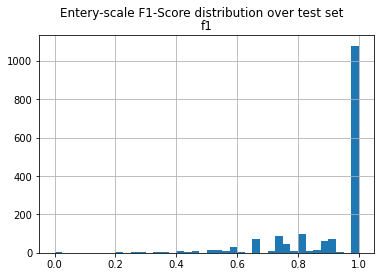

In [56]:
import pylab as pl

df_f1.hist(column='f1',bins=40,sharey=True, sharex=True)
pl.suptitle('Entery-scale F1-Score distribution over test set')

### 15-Top worst

In [59]:
for i in range(len(df_f1[0:14])):
    print(f"INDEX {i}")
    print(df_f1.iloc[i]["entry"])
    print(rdf.iloc[i]["entry_xml"])
    print(f"F1-Score : {df_f1.iloc[i]['f1']}")
    print("")

INDEX 0
Chardin et comp. fabr. de boutons de métal artimomantico, par brevet d'in- vention, à Vaugirard.
<PER>Aubourg</PER>, <ACT>limonadier</ACT>, <SPAT><LOC>St-Antoine</LOC>, <CARDINAL>104</CARDINAL></SPAT>.
F1-Score : 0.0

INDEX 1
Dauchez (E. ), référendaire à la cour des Comptes, des Vignes à Passy.
<PER>Dargaud</PER>, <ACT>tailleur</ACT>, <SPAT><LOC>Chaussée-d'Antin</LOC>, <CARDINAL>48</CARDINAL></SPAT>.
F1-Score : 0.0

INDEX 2
Gagnery, fabricant, par brevet d'in- vention, de mannequins perfec- tionnés se tenant sur leurs jam- bes sans le secours d'un pied ni d'aucun support, et offrant l'a- vantage de se grouper aussi près l'un de l'autre qu'on le désire, sans que rien puisse gêner le mouvement des jambes ; assorti- ment de mannequins ordinaires à des prix très-modérés, St Mar- tin, 257, M. H. 1849.*
<PER>Dauphin</PER>, <ACT>peintre</ACT>, <SPAT><LOC>Perche</LOC>, <CARDINAL>7</CARDINAL></SPAT>.
F1-Score : 0.2105263157894737

INDEX 3
Gaussen et Pouzadoux, châles. Banque, 1. *
<PER

### 15-Top best

In [60]:
rdf = df_f1.sort_values(by='f1', ascending=False)
for i in range(len(rdf[0:14])):
    print(rdf.iloc[i]["entry"])
    print(rdf.iloc[i]["entry_xml"])
    print(f"F1-Score : {rdf.iloc[i]['f1']}")
    print("")

Aubourg, limonadier, St-Antoine, 104.
<PER>Aubourg</PER>, <ACT>limonadier</ACT>, <SPAT><LOC>St-Antoine</LOC>, <CARDINAL>104</CARDINAL></SPAT>.
F1-Score : 1.0

Dargaud, tailleur, Chaussée-d'Antin, 48.
<PER>Dargaud</PER>, <ACT>tailleur</ACT>, <SPAT><LOC>Chaussée-d'Antin</LOC>, <CARDINAL>48</CARDINAL></SPAT>.
F1-Score : 1.0

Dauphin, peintre, Perche, 7.
<PER>Dauphin</PER>, <ACT>peintre</ACT>, <SPAT><LOC>Perche</LOC>, <CARDINAL>7</CARDINAL></SPAT>.
F1-Score : 1.0

Dauner (F.), négoc. en toiles, St-Martin, 88.
<PER>Dauner (F.</PER>), <ACT>négoc. en toiles</ACT>, <SPAT><LOC>St-Martin</LOC>, <CARDINAL>88</CARDINAL></SPAT>.
F1-Score : 1.0

Daup et Cie, lampes et bronzes, Bondy, 80.
<PER>Daup et Cie</PER>, <ACT>lampes et bronzes</ACT>, <SPAT><LOC>Bondy</LOC>, <CARDINAL>80</CARDINAL></SPAT>.
F1-Score : 1.0

Daupeley, commiss. -priseur, Hazard, 15.
<PER>Daupeley</PER>, <ACT>commiss. -priseur</ACT>, <SPAT><LOC>Hazard</LOC>, <CARDINAL>15</CARDINAL></SPAT>.
F1-Score : 1.0

Daupeyroux, vins, Varennes

## Sub-word global analysis

In [61]:
flat_preds = []
flat_labels = []
for i in range(len(df)):
    flat_preds += df["tags_preds"][i]
    flat_labels += df["tags_gold"][i]
flat_preds = pd.Series(flat_preds, name="Predictions")
flat_labels = pd.Series(flat_labels, name="Gold")

global_confusion = pd.crosstab(flat_labels, flat_preds,normalize='index').multiply(100., axis=1)

col = []
for c in global_confusion.columns:
    c = c.replace('I-','')
    c = c.replace('i_','')
    c = c.replace('B-','')
    c = c.replace('b_','')
    col.append(c)
global_confusion.columns = col

ind = []
for c in global_confusion.index:
    c = c.replace('I-','')
    c = c.replace('i_','')
    c = c.replace('B-','')
    c = c.replace('b_','')
    ind.append(c)
global_confusion.index = ind
global_confusion

,O+CARDINAL,O+LOC,ACT+O,ACT+LOC,DESC+O,DESC+CARDINAL,DESC+LOC,DESC+TITREP,PER+O,PER+LOC,PER+TITREH,SPAT+O,SPAT+CARDINAL,SPAT+LOC,O+O
ACT+O,0.000000,0.000000,92.974528,0.000000,1.663928,0.000000,0.000000,0.000000,1.869351,0.000000,0.000000,0.677896,0.000000,0.123254,2.691044
DESC+O,0.000000,0.000000,29.160187,0.000000,62.752722,0.000000,0.155521,0.000000,2.255054,0.311042,0.000000,0.000000,0.000000,0.388802,4.976672
DESC+ACT,0.000000,0.000000,51.333333,0.000000,47.777778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.888889
DESC+TITREP,0.000000,0.000000,0.000000,0.000000,70.614035,0.877193,1.315789,0.877193,0.000000,0.000000,0.000000,2.192982,0.000000,0.000000,24.122807
PER+O,0.000000,0.000000,0.233879,0.000000,0.000000,0.000000,0.000000,0.000000,99.281657,0.066823,0.033411,0.183762,0.000000,0.033411,0.167056
PER+TITREH,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.826446,0.000000,99.173554,0.000000,0.000000,0.000000,0.000000
SPAT+O,0.000000,0.000000,0.107239,0.000000,0.053619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,97.694370,0.321716,1.179625,0.643432
SPAT+CARDINAL,0.108519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.054259,99.728703,0.054259,0.054259
SPAT+FT,0.000000,0.000000,32.558140,0.000000,23.255814,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.232558,0.000000,11.627907,2.325581
SPAT+LOC,0.000000,0.447427,0.044743,0.123043,0.000000,0.000000,0.123043,0.000000,0.000000,0.022371,0.000000,0.447427,0.011186,98.713647,0.067114


Confusion matrix of reference and predicted tokens types.
Values are normalized by row (percentage of each reference classe and its resultants predictions)
Last row represent percentage of each class in gold.


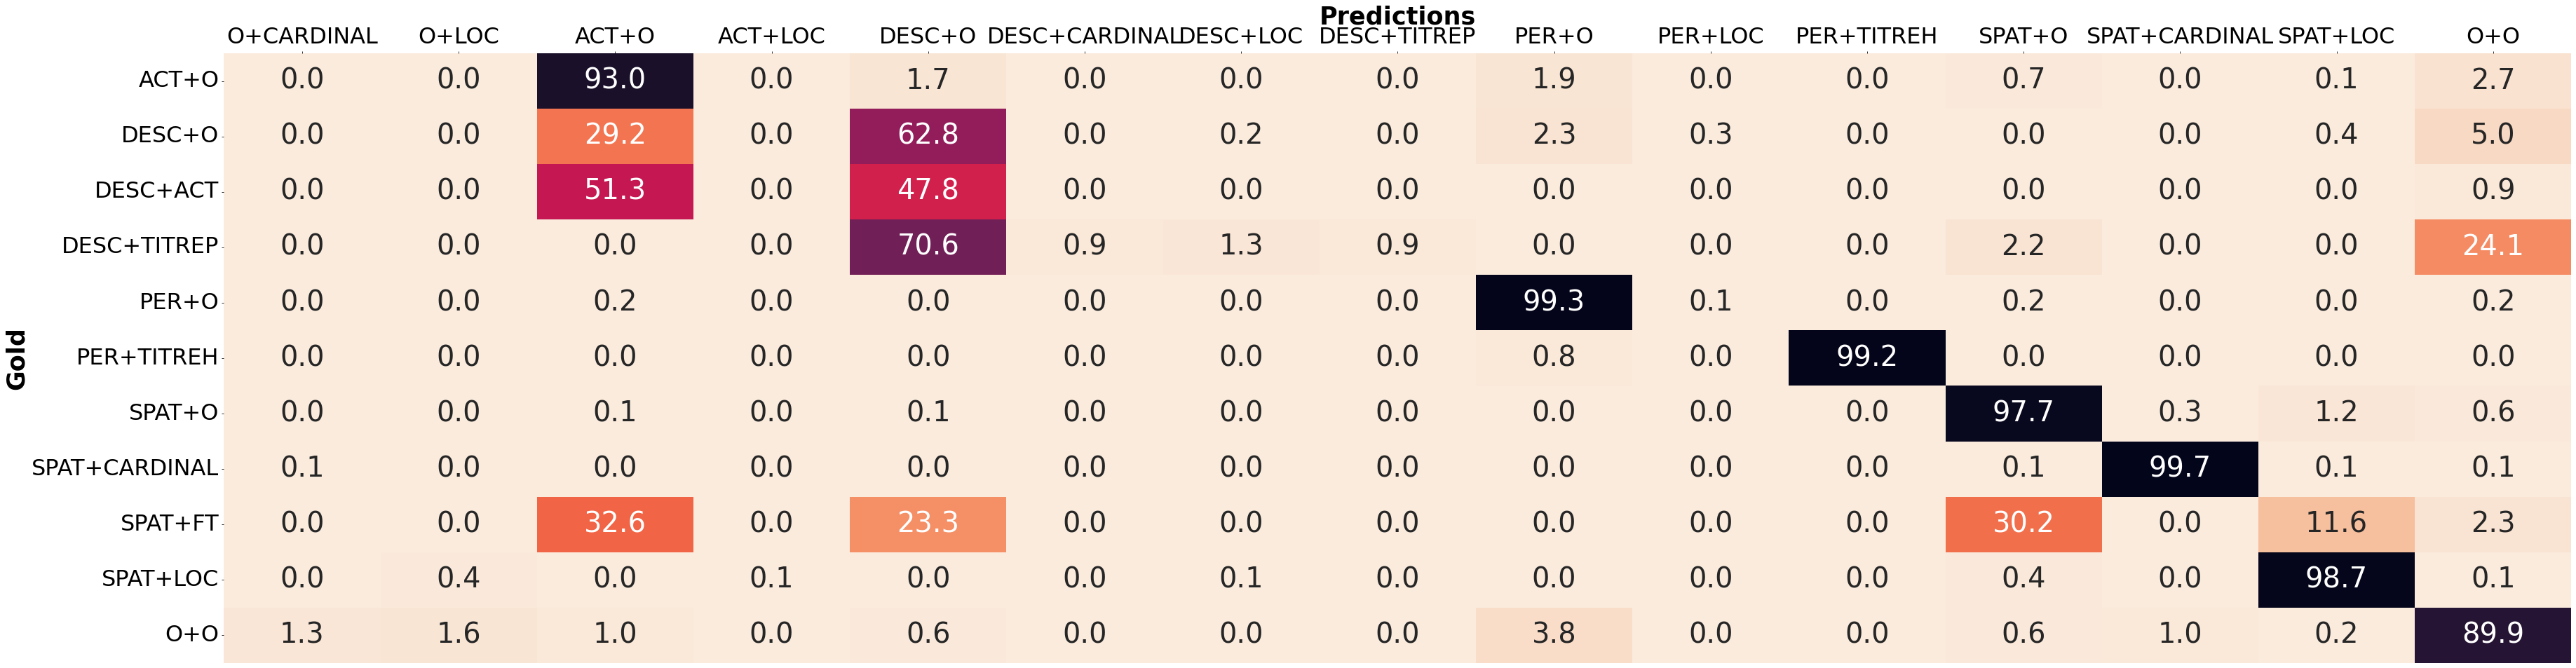

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Init figure
plt.figure(figsize=(60, 16))

#Create heatmap
snsfig = sns.heatmap(
    global_confusion, 
    annot = True, #Display labels
    cmap=sns.color_palette("rocket_r", as_cmap=True), #Color
    fmt=".1f",
    cbar=False,
    annot_kws={"fontsize":40}
)

#Rename label axis and set their style
plt.xlabel('Predictions',weight = 'bold',fontsize=35)
plt.ylabel('Gold',weight = 'bold',fontsize=35)

#Set x labels position to top
snsfig.xaxis.tick_top()
snsfig.xaxis.set_label_position('top')

#Rotate y ticks horizontaly
plt.yticks(rotation=0) 

#Change ticks size
snsfig.set_xticklabels(snsfig.get_xmajorticklabels(), fontsize = 32)
snsfig.set_yticklabels(snsfig.get_ymajorticklabels(), fontsize = 32)

print("Confusion matrix of reference and predicted tokens types.")
print("Values are normalized by row (percentage of each reference classe and its resultants predictions)")
print("Last row represent percentage of each class in gold.")

plt.show()

#Save figure
fig = snsfig.get_figure()
fig.tight_layout()
#fig.savefig(f"./tokenscaleanalysis-{FORMAT}-{SET}.pdf") 

## Entry scale analysis

Please choose one entry giving its index to perform an entry scale analysis :

In [63]:
i = 2

In [64]:
print(df.iloc[i]["entry"])
print(df.iloc[i]["entry_xml"])

Berchet, r. du Temple, 71.
<PER>Berchet</PER>, <SPAT><LOC>r. du Temple</LOC>, <CARDINAL>71</CARDINAL></SPAT>.


In [65]:
from seqeval.metrics import classification_report

y_preds = df.iloc[i]["tags_preds"]
y_true = df.iloc[i]["tags_gold"]
print(classification_report([y_true],[y_preds]))

                   precision    recall  f1-score   support

          i_PER+O       1.00      1.00      1.00         1
         i_SPAT+O       1.00      1.00      1.00         1
i_SPAT+i_CARDINAL       1.00      1.00      1.00         1
     i_SPAT+i_LOC       1.00      1.00      1.00         1

        micro avg       1.00      1.00      1.00         4
        macro avg       1.00      1.00      1.00         4
     weighted avg       1.00      1.00      1.00         4



/lrde/home2/stual/.venv/python_3_9/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: O+O seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y_true = pd.Series(df["tags_gold"].iloc[i], name='Gold')
y_pred = pd.Series(df["tags_preds"].iloc[i], name='Predictions')
entry_confusion = pd.crosstab(y_true, y_pred)

col = []
for c in entry_confusion.columns:
    c = c.replace('I-','')
    c = c.replace('i_','')
    c = c.replace('B-','')
    c = c.replace('b_','')
    col.append(c)
entry_confusion.columns = col

ind = []
for c in entry_confusion.index:
    c = c.replace('I-','')
    c = c.replace('i_','')
    c = c.replace('B-','')
    c = c.replace('b_','')
    ind.append(c)
entry_confusion.index = ind
entry_confusion

,PER+O,SPAT+O,SPAT+CARDINAL,SPAT+LOC,O+O
PER+O,2,0,0,0,0
SPAT+O,0,1,0,0,0
SPAT+CARDINAL,0,0,1,0,0
SPAT+LOC,0,0,0,4,0
O+O,0,0,0,0,2


Confusion matrix of reference and predicted tokens types.


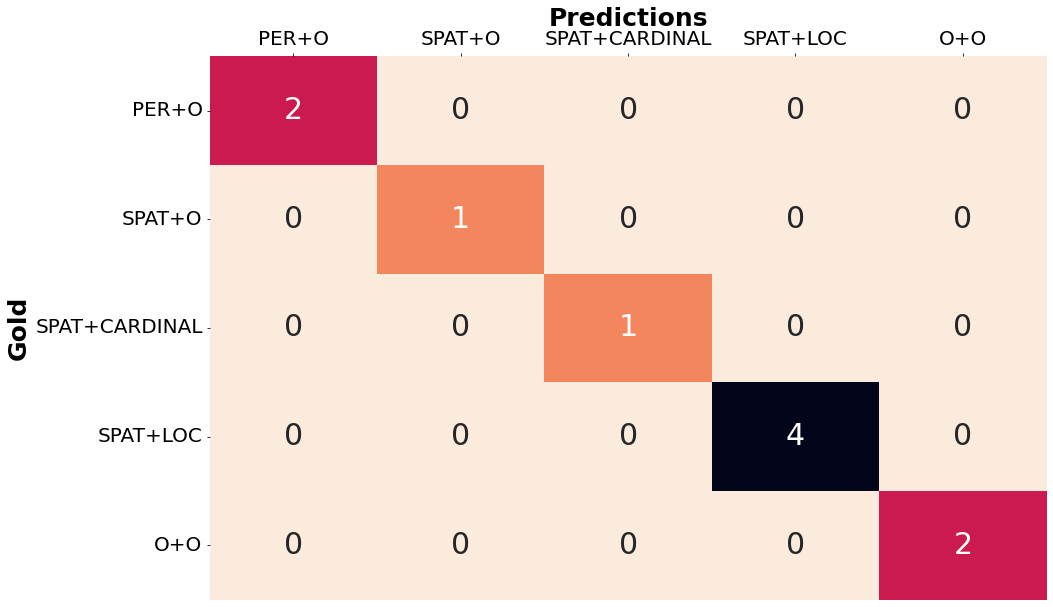

In [67]:
#Init figure
plt.figure(figsize=(15, 10))

#Create heatmap
snsfig = sns.heatmap(
    entry_confusion, 
    annot = True, #Display labels
    cmap=sns.color_palette("rocket_r", as_cmap=True), #Color
    fmt="g",
    cbar=False,
    annot_kws={"fontsize":30}
)

#Rename label axis and set their style
plt.xlabel('Predictions',weight = 'bold',fontsize=25) # x-axis label with fontsize 15
plt.ylabel('Gold',weight = 'bold',fontsize=25) # y-axis label with fontsize 15

#Set x labels position to top
snsfig.xaxis.tick_top()
snsfig.xaxis.set_label_position('top')

#Rotate y ticks horizontaly
plt.yticks(rotation=0) 

#Change ticks size
snsfig.set_xticklabels(snsfig.get_xmajorticklabels(), fontsize = 20)
snsfig.set_yticklabels(snsfig.get_ymajorticklabels(), fontsize = 20)

print("Confusion matrix of reference and predicted tokens types.")

plt.show()

#Save figure
fig = snsfig.get_figure()